<a href="https://colab.research.google.com/github/dushyantnagar7806/Deep-Leaning-Projects/blob/main/GANs_catImage.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install opendatasets
!pip install pandas

In [ ]:

import opendatasets as od
import pandas

od.download(
    "https://www.kaggle.com/datasets/spandan2/cats-faces-64x64-for-generative-models",force=True)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: dushyantnagar7806
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/spandan2/cats-faces-64x64-for-generative-models


100%|██████████| 96.0M/96.0M [00:01<00:00, 99.6MB/s]


In [ ]:
!pip install torch torchvision matplotlib
import matplotlib.pyplot as plt
import numpy as np
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
import torchvision.datasets as datasets

from torchvision.datasets import ImageFolder
import torchvision.transforms as tt
import torch
import torch.nn as nn

from tqdm.notebook import tqdm
import torch.nn.functional as F
from torchvision.utils import save_image
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
%matplotlib inline


In [49]:
DATA_DIR = '/content/cats-faces-64x64-for-generative-models'

In [50]:
print(os.listdir(DATA_DIR))

['cats']


In [51]:
print(os.listdir(DATA_DIR+'/cats')[:10])

['15226.jpg', '5802.jpg', '15108.jpg', '10823.jpg', '6169.jpg', '6763.jpg', '4397.jpg', '9610.jpg', '232.jpg', '14030.jpg']


In [52]:
image_size = 64
batch_size = 128
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

train_ds = ImageFolder(DATA_DIR, transform=tt.Compose([ tt.Resize(image_size),
                                                        tt.CenterCrop(image_size),
                                                        tt.ToTensor(),
                                                        tt.Normalize(*stats)]))

train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=3, pin_memory=True)

In [53]:
latent_size = 100
generator = nn.Sequential(
    # in: latent_size x 1 x 1

    nn.ConvTranspose2d(latent_size, 512, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    # out: 512 x 4 x 4

    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    # out: 256 x 8 x 8

    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    # out: 128 x 16 x 16

    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    # out: 64 x 32 x 32

    nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh()
    # out: 3 x 64 x 64
)

In [54]:
discriminator = nn.Sequential(
    # in: 3 x 64 x 64

    nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 64 x 32 x 32

    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 128 x 16 x 16

    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 256 x 8 x 8

    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 512 x 4 x 4

    nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),
    # out: 1 x 1 x 1

    nn.Flatten(),
    nn.Sigmoid())

In [55]:
sample_dir = 'generated'
os.makedirs(sample_dir, exist_ok=True)

def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]

def save_samples(index, latent_tensors, show=True):
    fake_images = generator(latent_tensors)
    fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
    print('Saving', fake_fname)
    if show:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))

In [56]:
def train_discriminator(real_images, opt_d):
    # Clear discriminator gradients
    opt_d.zero_grad()

    # Pass real images through discriminator
    real_preds = discriminator(real_images)
    real_targets = torch.ones(real_images.size(0), 1)
    real_loss = F.binary_cross_entropy(real_preds, real_targets)
    real_score = torch.mean(real_preds).item()

    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1)
    fake_images = generator(latent)

    # Pass fake images through discriminator
    fake_targets = torch.zeros(fake_images.size(0), 1)
    fake_preds = discriminator(fake_images)
    fake_loss = F.binary_cross_entropy(fake_preds, fake_targets)
    fake_score = torch.mean(fake_preds).item()

    # Update discriminator weights
    loss = real_loss + fake_loss
    loss.backward()
    opt_d.step()
    return loss.item(), real_score, fake_score

In [57]:
def train_generator(opt_g):
    # Clear generator gradients
    opt_g.zero_grad()

    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1)
    fake_images = generator(latent)

    # Try to fool the discriminator
    preds = discriminator(fake_images)
    targets = torch.ones(batch_size, 1)
    loss = F.binary_cross_entropy(preds, targets)

    # Update generator weights
    loss.backward()
    opt_g.step()

    return loss.item()

In [58]:
fixed_latent = torch.randn(64, latent_size, 1, 1)
def fit(epochs, lr, start_idx=1):
    torch.cuda.empty_cache()

    # Losses & scores
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []

    # Create optimizers
    opt_d = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
    opt_g = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))

    for epoch in range(epochs):
        for real_images, _ in tqdm(train_dl):
            # Train discriminator
            loss_d, real_score, fake_score = train_discriminator(real_images, opt_d)
            # Train generator
            loss_g = train_generator(opt_g)

        # Record losses & scores
        losses_g.append(loss_g)
        losses_d.append(loss_d)
        real_scores.append(real_score)
        fake_scores.append(fake_score)

        # Log losses & scores (last batch)
        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
            epoch+1, epochs, loss_g, loss_d, real_score, fake_score))

        # Save generated images
        save_samples(epoch+start_idx, fixed_latent, show=False)

    return losses_g, losses_d, real_scores, fake_scores

In [59]:
history = fit(epochs=5, lr=0.0002)

  0%|          | 0/247 [00:00<?, ?it/s]

Epoch [1/5], loss_g: 5.1359, loss_d: 0.2351, real_score: 0.8238, fake_score: 0.0337
Saving generated-images-0001.png


  0%|          | 0/247 [00:00<?, ?it/s]

Epoch [2/5], loss_g: 3.5134, loss_d: 0.8014, real_score: 0.6798, fake_score: 0.3042
Saving generated-images-0002.png


  0%|          | 0/247 [00:00<?, ?it/s]

Epoch [3/5], loss_g: 3.2918, loss_d: 0.5060, real_score: 0.7200, fake_score: 0.1381
Saving generated-images-0003.png


  0%|          | 0/247 [00:00<?, ?it/s]

Epoch [4/5], loss_g: 3.9784, loss_d: 0.4176, real_score: 0.8548, fake_score: 0.2037
Saving generated-images-0004.png


  0%|          | 0/247 [00:00<?, ?it/s]

Epoch [5/5], loss_g: 3.1789, loss_d: 0.3670, real_score: 0.9046, fake_score: 0.2088
Saving generated-images-0005.png


In [62]:
losses_g, losses_d, real_scores, fake_scores = history

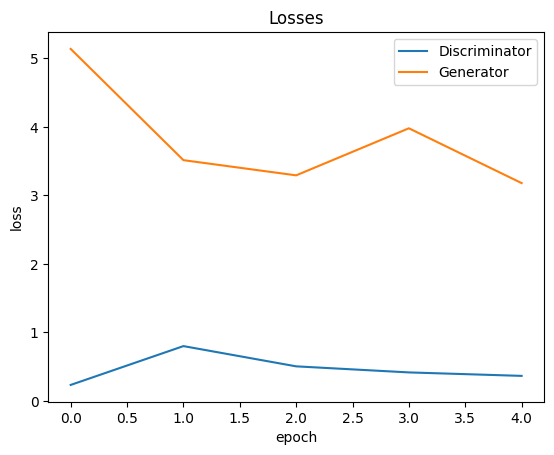

In [63]:
plt.plot(losses_d, '-')
plt.plot(losses_g, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses');

In [64]:
history = fit(epochs=10, lr=0.0001)

  0%|          | 0/247 [00:00<?, ?it/s]

Epoch [1/10], loss_g: 5.5699, loss_d: 0.1774, real_score: 0.9804, fake_score: 0.1351
Saving generated-images-0001.png


  0%|          | 0/247 [00:00<?, ?it/s]

Epoch [2/10], loss_g: 2.7825, loss_d: 0.3286, real_score: 0.7844, fake_score: 0.0403
Saving generated-images-0002.png


  0%|          | 0/247 [00:00<?, ?it/s]

Epoch [3/10], loss_g: 6.5837, loss_d: 0.4756, real_score: 0.9075, fake_score: 0.2856
Saving generated-images-0003.png


  0%|          | 0/247 [00:00<?, ?it/s]

Epoch [4/10], loss_g: 0.0509, loss_d: 1.6826, real_score: 0.2353, fake_score: 0.0592
Saving generated-images-0004.png


  0%|          | 0/247 [00:00<?, ?it/s]

Epoch [5/10], loss_g: 2.0568, loss_d: 0.6258, real_score: 0.7465, fake_score: 0.0803
Saving generated-images-0005.png


  0%|          | 0/247 [00:00<?, ?it/s]

Epoch [6/10], loss_g: 3.9729, loss_d: 0.1909, real_score: 0.9047, fake_score: 0.0810
Saving generated-images-0006.png


  0%|          | 0/247 [00:00<?, ?it/s]

Epoch [7/10], loss_g: 4.6260, loss_d: 0.1400, real_score: 0.9376, fake_score: 0.0682
Saving generated-images-0007.png


  0%|          | 0/247 [00:00<?, ?it/s]

Epoch [8/10], loss_g: 2.9966, loss_d: 0.3067, real_score: 0.7985, fake_score: 0.0569
Saving generated-images-0008.png


  0%|          | 0/247 [00:00<?, ?it/s]

Epoch [9/10], loss_g: 5.0768, loss_d: 0.4573, real_score: 0.6951, fake_score: 0.0114
Saving generated-images-0009.png


  0%|          | 0/247 [00:00<?, ?it/s]

Epoch [10/10], loss_g: 2.2119, loss_d: 0.6833, real_score: 0.5862, fake_score: 0.0079
Saving generated-images-0010.png


In [65]:
losses_g, losses_d, real_scores, fake_scores = history

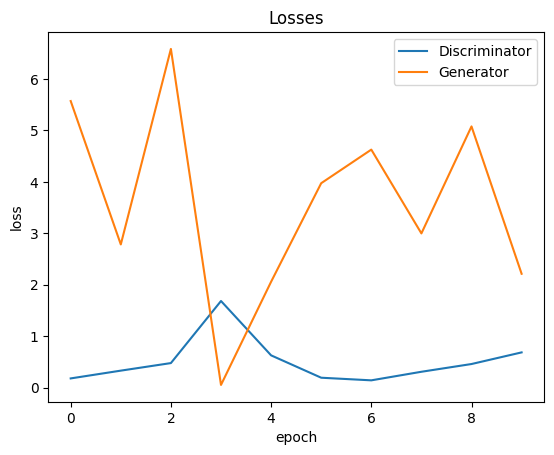

In [66]:
plt.plot(losses_d, '-')
plt.plot(losses_g, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses');